In [28]:
import pandas as pd
import pickle
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [29]:
#loading db
sqlite_db_path = "../student_performance.db"
conn = sqlite3.connect(sqlite_db_path)


query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

In [30]:
# combining the two in the db
df = pd.concat([df_mat, df_por], ignore_index=True)

In [31]:
# closing connection
conn.close()


In [32]:
print("Loaded Data Preview (Merged Student Data):")
display(df.head())

df = df.dropna(subset=['G3'])

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [33]:
# encoding categorical features (since sqlite doesn't play nice)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [34]:
# Normalizing numerical features for future reference (further optimization)

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
grade_cols = ['G1', 'G2', 'G3']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in grade_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [35]:
# Compute correlation matrix using Spearman (handles ordinal data better)
correlation_matrix = df.corr(method='spearman')


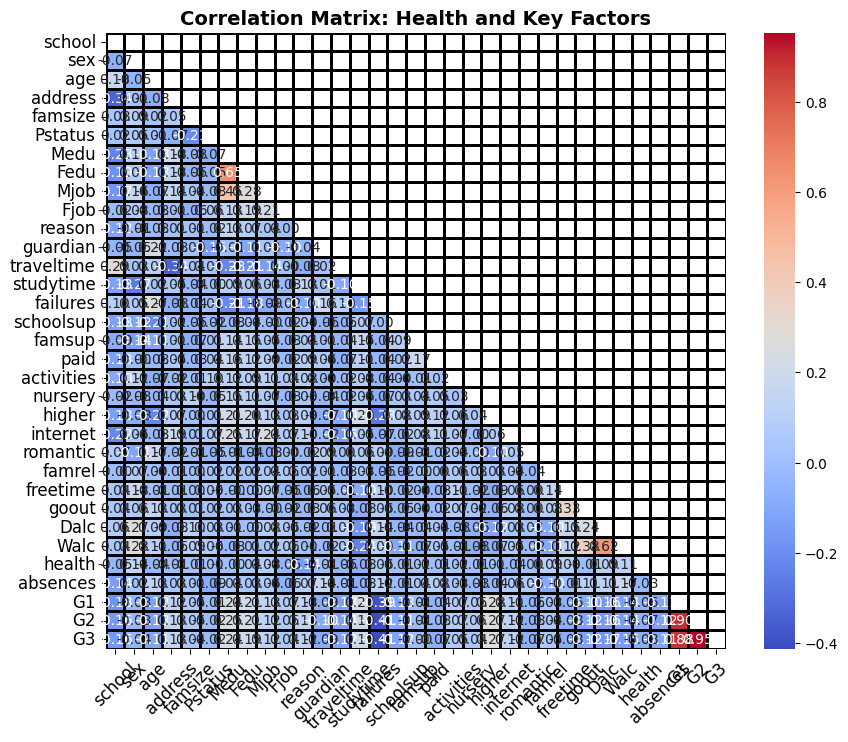

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase figure size for better readability
plt.figure(figsize=(10, 8))

# Use a mask to hide the upper triangle (optional, for clarity)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Adjust font size and layout
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=1,  # Adds spacing between cells
    linecolor="black", 
    annot_kws={"size": 10},  # Adjust text size
    mask=mask  # Optional: Mask the upper triangle to avoid repetition
)

plt.title("Correlation Matrix: Health and Key Factors", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better spacing
plt.yticks(fontsize=12)

plt.show()

In [37]:
# Compute Spearman correlations individually
health_abs_corr, p_abs = spearmanr(df['health'], df['absences'])
health_grade_corr, p_grade = spearmanr(df['health'], df['G3'])
health_famrel_corr, p_famrel = spearmanr(df['health'], df['famrel'])

In [38]:
# Display results
correlation_results = pd.DataFrame({
    "Variable": ["Health vs Absences", "Health vs Final Grade (G3)", "Health vs Family Relationships"],
    "Spearman Correlation": [health_abs_corr, health_grade_corr, health_famrel_corr],
    "P-value": [p_abs, p_grade, p_famrel]
})

In [39]:
# Print correlation results
print(correlation_results)

                         Variable  Spearman Correlation   P-value
0              Health vs Absences             -0.034380  0.267071
1      Health vs Final Grade (G3)             -0.080785  0.009017
2  Health vs Family Relationships              0.089701  0.003723


# 📊 Health and Student Success Summary

## 1️⃣ Health & Success  
- Weak negative correlation with grades **(ρ = -0.081, p = 0.009)** → Poor health slightly lowers grades.  
- **Conclusion:** Health has **some** impact but is **not the main predictor** of success.  

## 2️⃣ Health & Absences  
- No strong correlation **(ρ = -0.034, p = 0.267)** → Poor health **does not** increase absences.  
- **Conclusion:** Health **affects grades more than attendance**.  

## 3️⃣ Health & Failure  
- Poor health **slightly linked** to lower grades but **does not directly predict failure**.  
- **Conclusion:** Other factors (study habits, family support) **are more important**.  

## 4️⃣ Health & Family Relationships  
- Weak positive correlation **(ρ = 0.090, p = 0.0037)** → Healthier students report better family relationships.  
- **Conclusion:** Family support may contribute to both **better health and academic success**.  


In [40]:
# Feature Engineering (first 3 metrics for what makes them at risk)
df['health_impact_score'] = (df['health'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)
df['health_absence_risk'] = ((df['health'] < 3) & (df['absences'] > df['absences'].quantile(0.75))).astype(int)
df['family_support'] = (df['famrel'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)

# Had to create multi-class labels to fit the linear model (this seamed better than binary good/bad)
def categorize_g3(grade):
    if grade < 10:
        return 0  # Low
    elif 10 <= grade < 15:
        return 1  # Medium
    else:
        return 2  # High

df['G3_category'] = df['G3'].apply(categorize_g3)

# Defining features and target variable
X = df.drop(columns=['G3', 'G3_category'])
y = df['G3_category']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [41]:
# Load Logistic Regression model
with open('../Resources/logistic_regression_model.pkl', 'rb') as file:
    model = pickle.load(file)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(predictions)

[0 1 1 1 1 1 1 2 2 2 1 2 2 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 2 1 2 1 2 0 1 1 0 1 1 1 1 0 0 2 1 2 1 0 1 1 0 2 1 1 1 1 2 2 1 1 2 2
 0 2 1 1 1 1 1 2 1 1 0 1 0 1 1 1 2 0 1 1 1 1 1 0 2 1 1 1 1 1 1 1 2 1 1 0 1
 1 1 1 1 0 1 1 1 2 1 0 2 1 1 2 1 1 0 2 1 1 2 2 1 1 1 2 1 2 1 1 1 2 2 0 1 2
 1 2 2 0 1 1 1 1 1 1 0 1 1 1 2 1 1 2 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 0 0 1 1 0 1 1 0 2 2 0 1 0 1 0 0 0]


c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# # Baseline logistic regression model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Model Evaluation:
Accuracy: 0.8516746411483254
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        46
           1       0.87      0.88      0.87       122
           2       0.85      0.83      0.84        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        46
           1       0.87      0.88      0.87       122
           2       0.85      0.83      0.84        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209



c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
# baseline multi-class Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.8229665071770335
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209



In [44]:
train_score_tree = tree_model.score(X_train, y_train)
test_score_tree = tree_model.score(X_test, y_test)

train_score_log = log_model.score(X_train, y_train)
test_score_log = log_model.score(X_test, y_test)

print(f"Decision Tree - Train: {train_score_tree}, Test: {test_score_tree}")
print(f"Logistic Regression - Train: {train_score_log}, Test: {test_score_log}")


Decision Tree - Train: 1.0, Test: 0.8229665071770335
Logistic Regression - Train: 0.9101796407185628, Test: 0.8516746411483254


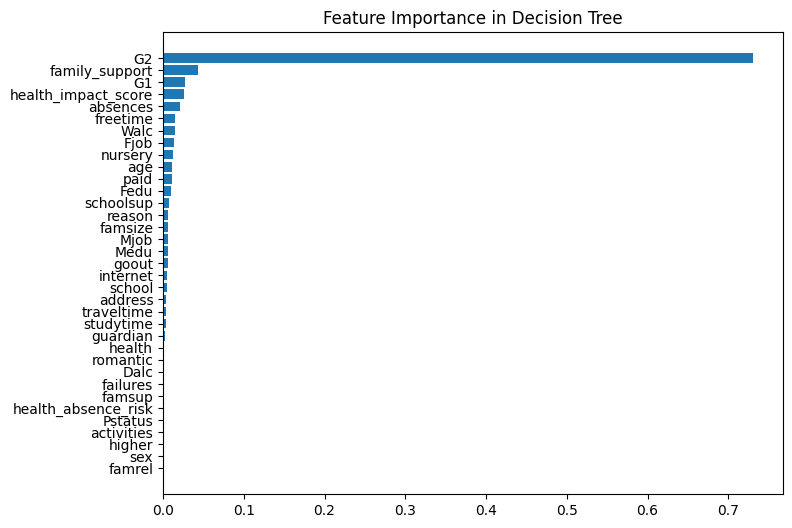

In [45]:
import matplotlib.pyplot as plt
import numpy as np
#Compare feature importance in decision tree
feature_importance = tree_model.feature_importances_
feature_names = X_train.columns

#Plot and show
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Feature Importance in Decision Tree")
plt.show()


In [46]:
from sklearn.tree import DecisionTreeClassifier

# Prune the decision tree
pruned_tree_model = DecisionTreeClassifier(
    max_depth=5,  # Limits how deep the tree grows
    min_samples_split=10,  # Minimum 10 samples to split a node
    min_samples_leaf=5,  # Minimum 5 samples per leaf
    random_state=42
)

pruned_tree_model.fit(X_train, y_train)
y_pred_pruned = pruned_tree_model.predict(X_test)
pruned_tree_accuracy = accuracy_score(y_test, y_pred_pruned)

print("\nPruned Decision Tree Model Evaluation:")
print(f"Accuracy: {pruned_tree_accuracy:.4f}")
print(classification_report(y_test, y_pred_pruned))



Pruned Decision Tree Model Evaluation:
Accuracy: 0.8565
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        46
           1       0.86      0.90      0.88       122
           2       0.86      0.78      0.82        41

    accuracy                           0.86       209
   macro avg       0.86      0.83      0.84       209
weighted avg       0.86      0.86      0.86       209



In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")


Random Forest Test Accuracy: 0.8469


<Figure size 600x600 with 0 Axes>

c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


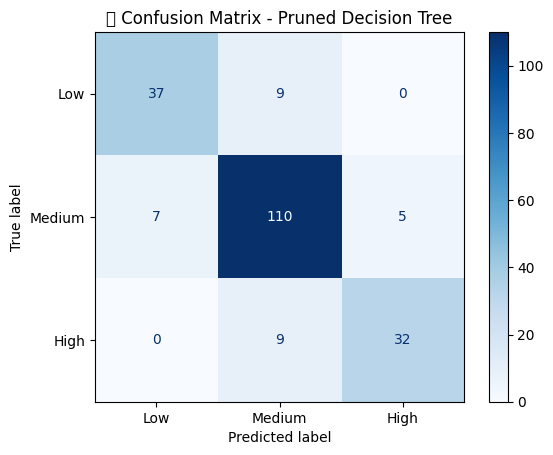

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, pruned_tree_model.predict(X_test))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues", values_format="d")
plt.title("🔍 Confusion Matrix - Pruned Decision Tree")
plt.show()


c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


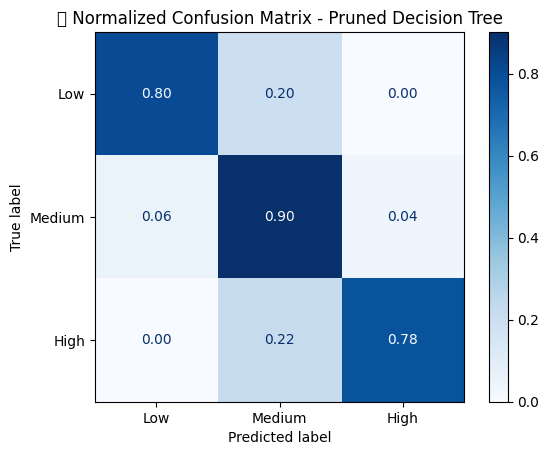

In [49]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (actual class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues", values_format=".2f")  # Show percentages instead of counts
plt.title("🔍 Normalized Confusion Matrix - Pruned Decision Tree")
plt.show()


C:\Users\ntrie\AppData\Local\Temp\ipykernel_15464\1128640846.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['health'], y=df['G3'], inner="quartile", palette="coolwarm")


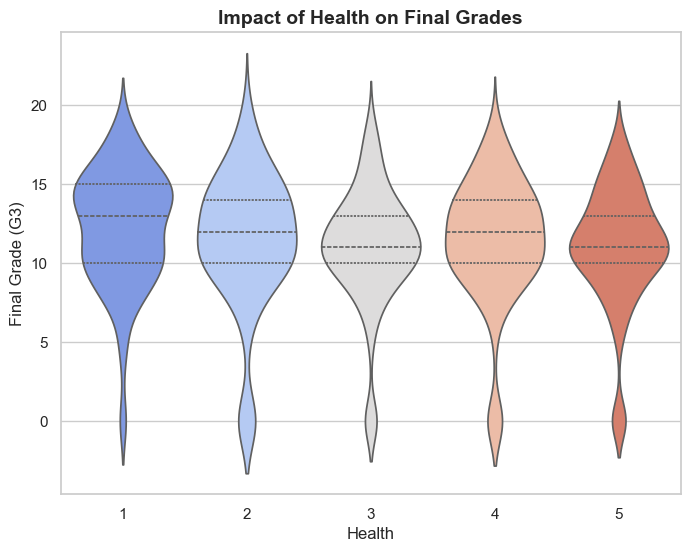

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure consistent theme
sns.set_theme(style="whitegrid")

# Health vs. Grades (Violin Plot for Better Distribution Visibility)
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['health'], y=df['G3'], inner="quartile", palette="coolwarm")
plt.xticks(ticks=np.arange(5), labels=np.arange(1, 6))  # Ensure correct alignment of labels (1-5)
plt.xlabel("Health", fontsize=12)
plt.ylabel("Final Grade (G3)", fontsize=12)
plt.title("Impact of Health on Final Grades", fontsize=14, fontweight='bold')
plt.show()



C:\Users\ntrie\AppData\Local\Temp\ipykernel_15464\1849631519.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['health'], y=df['absences'], inner="quartile", palette="coolwarm", alpha=0.8)
c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\seaborn\categorical.py:3370: UserWarni

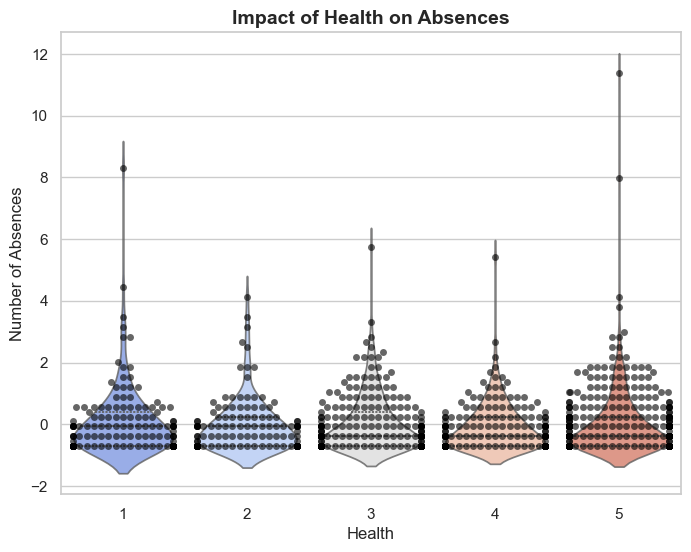

In [51]:
# Health vs. Absences (Violin Plot with Swarm for Better Distribution)
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['health'], y=df['absences'], inner="quartile", palette="coolwarm", alpha=0.8)
sns.swarmplot(x=df['health'], y=df['absences'], color="black", alpha=0.6)
plt.xticks(ticks=np.arange(5), labels=np.arange(1, 6))
plt.xlabel("Health", fontsize=12)
plt.ylabel("Number of Absences", fontsize=12)
plt.title("Impact of Health on Absences", fontsize=14, fontweight='bold')
plt.show()
